# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ace_tools_open as tools
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import re
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('data_football_ratings.csv')
tools.display_dataframe_to_user("", df)

# I. Statistiques descriptives

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50652 entries, 0 to 50651
Data columns (total 63 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   competition             50652 non-null  object 
 1   date                    50652 non-null  object 
 2   match                   50652 non-null  object 
 3   team                    50652 non-null  object 
 4   pos                     50652 non-null  object 
 5   pos_role                50652 non-null  object 
 6   player                  50652 non-null  object 
 7   rater                   50652 non-null  object 
 8   is_human                50652 non-null  int64  
 9   original_rating         50652 non-null  float64
 10  goals                   50652 non-null  int64  
 11  assists                 50652 non-null  int64  
 12  shots_ontarget          50652 non-null  int64  
 13  shots_offtarget         50652 non-null  int64  
 14  shotsblocked            50652 non-null

In [6]:
# Function to generate summary statistics for categorical variables
def generate_categorical_summary(column):
    summary = df[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    summary['Percentage'] = round((summary['Count'] / df.shape[0]) * 100, 2)
    return summary

# Generating summaries
teams_summary = generate_categorical_summary('team')
competitions_summary = generate_categorical_summary('competition')
players_summary = generate_categorical_summary('player')
raters_summary = generate_categorical_summary('rater')

# Display the summaries
tools.display_dataframe_to_user("Résumé des Équipes", teams_summary)
tools.display_dataframe_to_user("Résumé des Compétitions", competitions_summary)
tools.display_dataframe_to_user("Résumé des Joueurs", players_summary)
tools.display_dataframe_to_user("Résumé des Noteurs", raters_summary)

Résumé des Équipes


Résumé des Compétitions


Résumé des Joueurs


Résumé des Noteurs


In [7]:
# Variables numériques
data_types = df.dtypes
missing_values = df.isna().sum()
summary_with_types = df.describe()
summary_with_types.loc['Type'] = data_types
summary_with_types.loc['NA'] = missing_values

tools.display_dataframe_to_user("Summary", summary_with_types)

Summary


In [8]:
df2 = df
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%Y')
df2['year'] = df2['date'].dt.year

matches_year_championship = df.groupby(['year', 'competition'])['match'].nunique().reset_index()
matches_year_championship.columns = ['Year', 'Competition', 'Number of Matches']

tools.display_dataframe_to_user("Nombre de Matchs par Année et par Championnat", matches_year_championship)

Nombre de Matchs par Année et par Championnat


# II. Création de variables

In [9]:
# Variables de score

def get_awayteam_and_scores(match_str, team):
    """
    Returns (opp_team, team_score, opp_score).
    - match_str : "France - Romania, 2 - 1"
    - team      : name of the team (e.g., "France" or "Romania")
    """
    pattern = re.compile(r"^([^-]+)\s*-\s*([^,]+),\s*(\d+)\s*-\s*(\d+)$")
    match = pattern.match(match_str)
    if match:
        team1 = match.group(1).strip()
        team2 = match.group(2).strip()
        score1 = int(match.group(3))
        score2 = int(match.group(4))

        if team == team1:
            return (team2, score1, score2)
        elif team == team2:
            return (team1, score2, score1)
        else:
            return (None, None, None)
    else:
        return (None, None, None)

# Create new columns with the extracted infos
df['opp_team'], df['team_score'], df['opp_score'] = zip(*df.apply(
    lambda row: get_awayteam_and_scores(row['match'], row['team']), axis=1
))

df[['match', 'team', 'opp_team', 'team_score', 'opp_score']].head()

,match,team,opp_team,team_score,opp_score
0,"France - Romania, 2 - 1",Romania,France,1,2
1,"France - Romania, 2 - 1",Romania,France,1,2
2,"France - Romania, 2 - 1",Romania,France,1,2
3,"France - Romania, 2 - 1",France,Romania,2,1
4,"France - Romania, 2 - 1",Romania,France,1,2


In [10]:
# Variables temporelles
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['year'] = df['date'].dt.year
#df['semester'] = (df['date'].dt.month // 3) + (df['date'].dt.month % 3 > 0)
df['semester'] = ((df['date'].dt.month+2)//3)

In [11]:
# Variables catégorielles
columns_to_dummies = ['team', 'opp_team', 'competition', 'pos', 'pos_role', 'rater']
get_dum = pd.get_dummies(df[columns_to_dummies], prefix=columns_to_dummies)
df = pd.concat([df, get_dum], axis=1)

In [12]:
# Nous créons une colonne qui permet de vérifier le nombre d'occurence par joueur
# Cette variable permettra de rendre non sensible nos prédictions à la moyenne car si le joueur apparait une fois il a possibilité d'afficher des performances élevées par chance contrairement aux joueurs jouant plus souvent. Le nombre de fois où un joueur joue peut être signe de bonne perf.

df['nombre_apparitions'] = df['player'].map(df['player'].value_counts())

In [13]:
# Création de la variable higher_rater : 1 si rater est dans la liste donnée, 0 sinon
liste_raters = ['WhoScored', 'SofaScore', 'TheGuardian', 'SkySports']
df['higher_rater'] = np.where(df['rater'].isin(liste_raters), 1, 0)

In [14]:
# Création de la variable Substitute : 1 si Substitute est dans la liste donnée, 0 sinon
df['Substitute'] = np.where(df['pos_role'].isin(['Sub']), 1, 0)

# III. DataViz

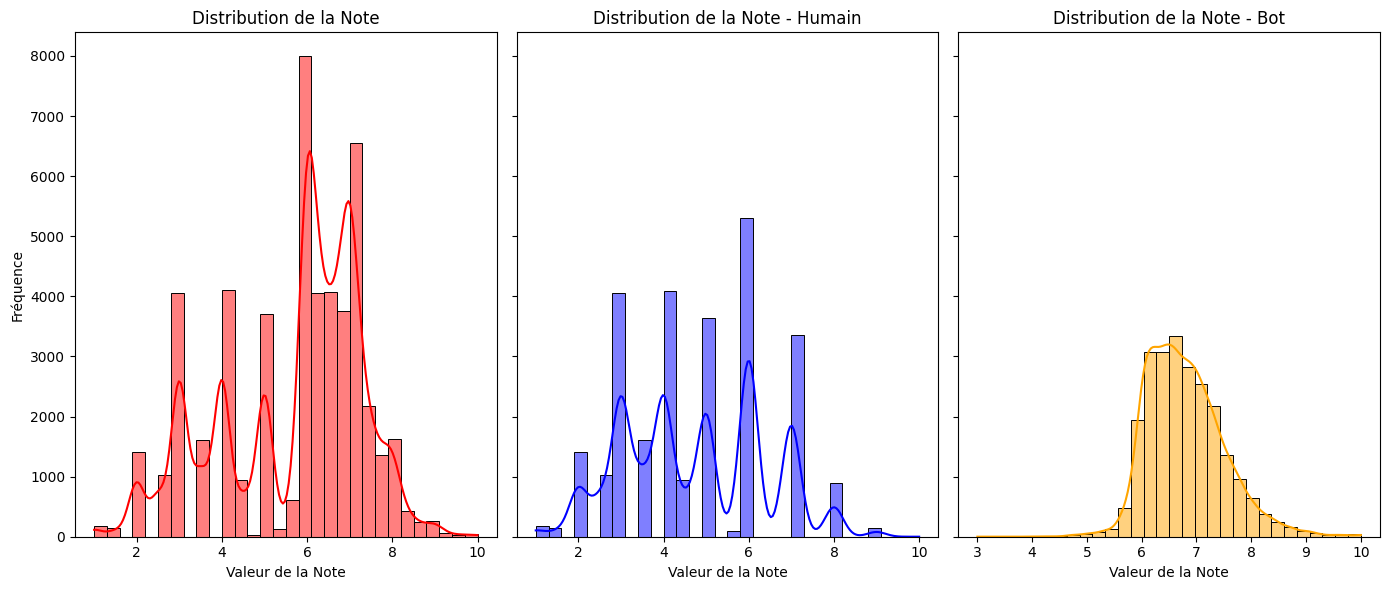

In [15]:
df_human = df[df['is_human']==1]
df_bot = df[df['is_human']==0]

# Créer un subplot avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

# Distribution des humains
sns.histplot(df['original_rating'], kde=True, bins=30, ax=axes[0], color='red')
axes[0].set_title("Distribution de la Note")
axes[0].set_xlabel("Valeur de la Note")
axes[0].set_ylabel("Fréquence")

# Distribution des humains
sns.histplot(df_human['original_rating'], kde=True, bins=30, ax=axes[1], color='blue')
axes[1].set_title("Distribution de la Note - Humain")
axes[1].set_xlabel("Valeur de la Note")
axes[1].set_ylabel("Fréquence")

# Distribution des bots
sns.histplot(df_bot['original_rating'], kde=True, bins=30, ax=axes[2], color='orange')
axes[2].set_title("Distribution de la Note - Bot")
axes[2].set_xlabel("Valeur de la Note")
axes[2].set_ylabel("Fréquence")

plt.tight_layout()
plt.show()

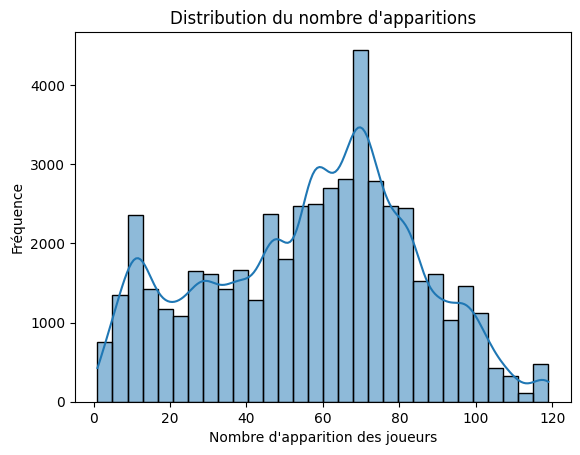

In [16]:
sns.histplot(df['nombre_apparitions'], kde=True, bins=30)
plt.title("Distribution du nombre d'apparitions")
plt.xlabel("Nombre d'apparition des joueurs")
plt.ylabel("Fréquence")
plt.show()

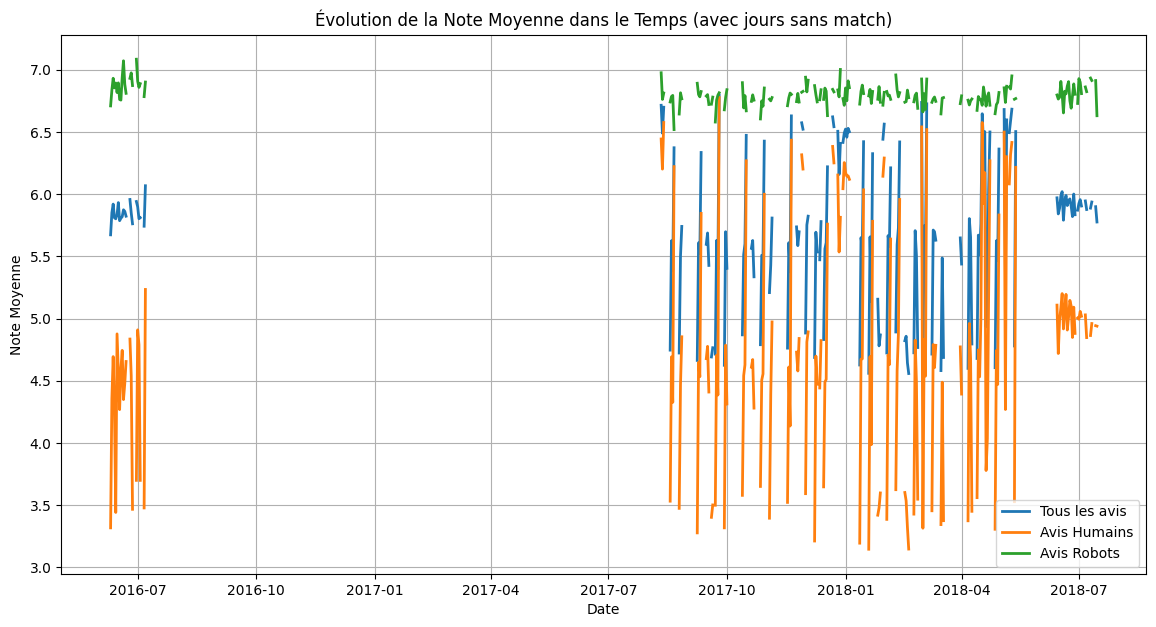

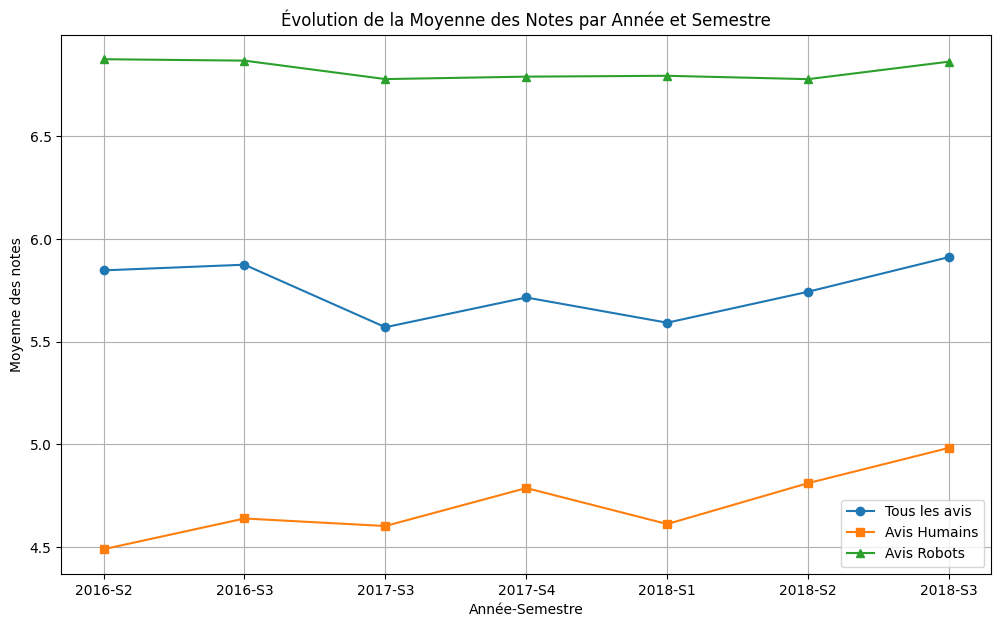

In [17]:
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

average_ratings_all = df.groupby('date')['original_rating'].mean().reindex(full_date_range)
average_ratings_human = df_human.groupby('date')['original_rating'].mean().reindex(full_date_range)
average_ratings_robot = df_bot.groupby('date')['original_rating'].mean().reindex(full_date_range)

semester_stats_all = df.groupby(['year', 'semester'])['original_rating'].agg(['mean', 'var']).reset_index()
semester_stats_human = df_human.groupby(['year', 'semester'])['original_rating'].agg(['mean', 'var']).reset_index()
semester_stats_robot = df_bot.groupby(['year', 'semester'])['original_rating'].agg(['mean', 'var']).reset_index()

semester_stats_all['year_semester'] = semester_stats_all['year'].astype(str) + "-S" + semester_stats_all['semester'].astype(str)
semester_stats_human['year_semester'] = semester_stats_human['year'].astype(str) + "-S" + semester_stats_human['semester'].astype(str)
semester_stats_robot['year_semester'] = semester_stats_robot['year'].astype(str) + "-S" + semester_stats_robot['semester'].astype(str)

plt.figure(figsize=(14, 7))
plt.plot(average_ratings_all.index, average_ratings_all.values, label='Tous les avis', linewidth=2)
plt.plot(average_ratings_human.index, average_ratings_human.values, label='Avis Humains', linewidth=2)
plt.plot(average_ratings_robot.index, average_ratings_robot.values, label='Avis Robots', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Note Moyenne')
plt.title("Évolution de la Note Moyenne dans le Temps (avec jours sans match)")
plt.legend()
plt.grid(True)
plt.show()

plt.subplots(figsize=(12, 7))
plt.xlabel('Année-Semestre')
plt.ylabel('Moyenne des notes')
plt.plot(semester_stats_all['year_semester'], semester_stats_all['mean'], marker='o', linestyle='-', label='Tous les avis')
plt.plot(semester_stats_human['year_semester'], semester_stats_human['mean'], marker='s', linestyle='-', label='Avis Humains')
plt.plot(semester_stats_robot['year_semester'], semester_stats_robot['mean'], marker='^', linestyle='-', label='Avis Robots')
plt.title("Évolution de la Moyenne des Notes par Année et Semestre")
plt.legend()
plt.grid(True)
plt.show()

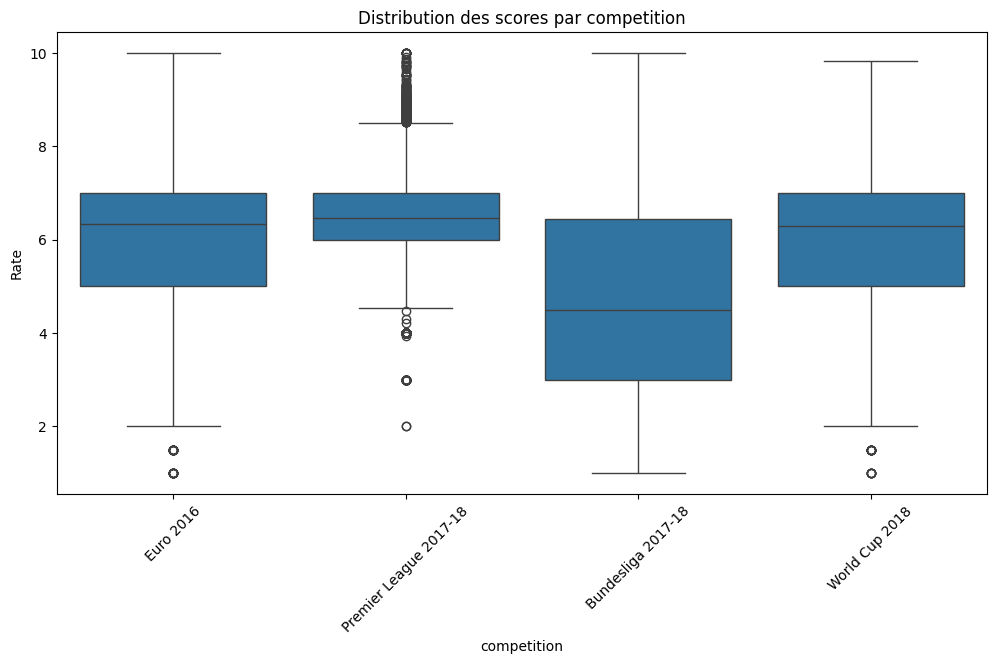

In [18]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='competition', y='original_rating')
plt.title('Distribution des scores par competition')
plt.xlabel('competition')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

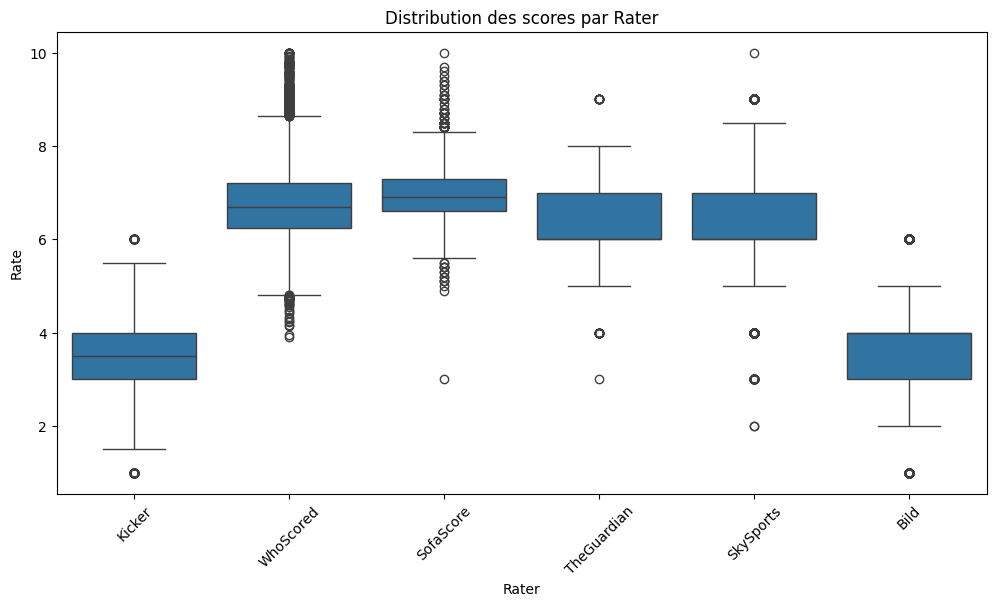

In [19]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='rater', y='original_rating')
plt.title('Distribution des scores par Rater')
plt.xlabel('Rater')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

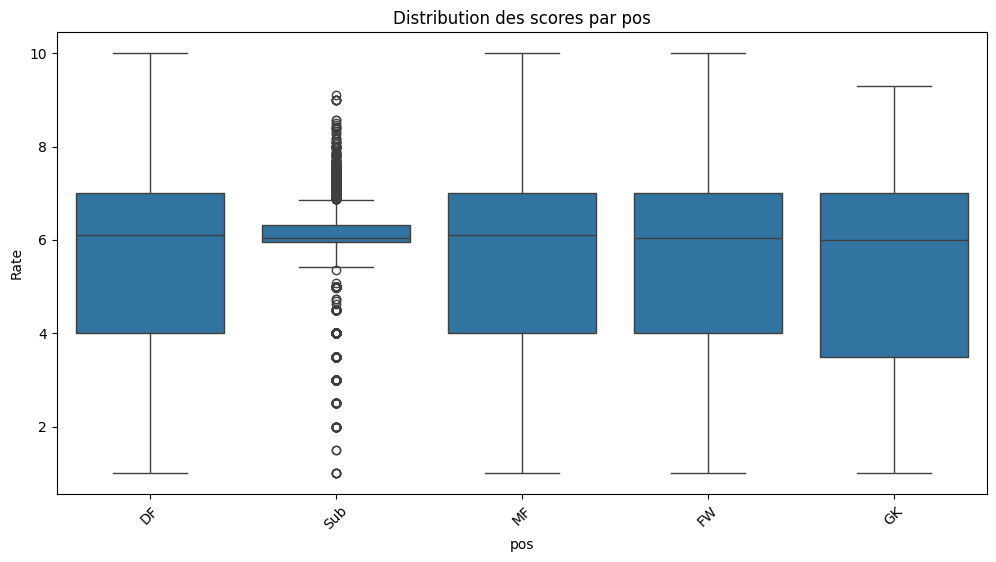

In [20]:
# Tracer les boxplots pour chaque rater
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='pos', y='original_rating')
plt.title('Distribution des scores par pos')
plt.xlabel('pos')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.show()

# IV. Analyse des corrélations

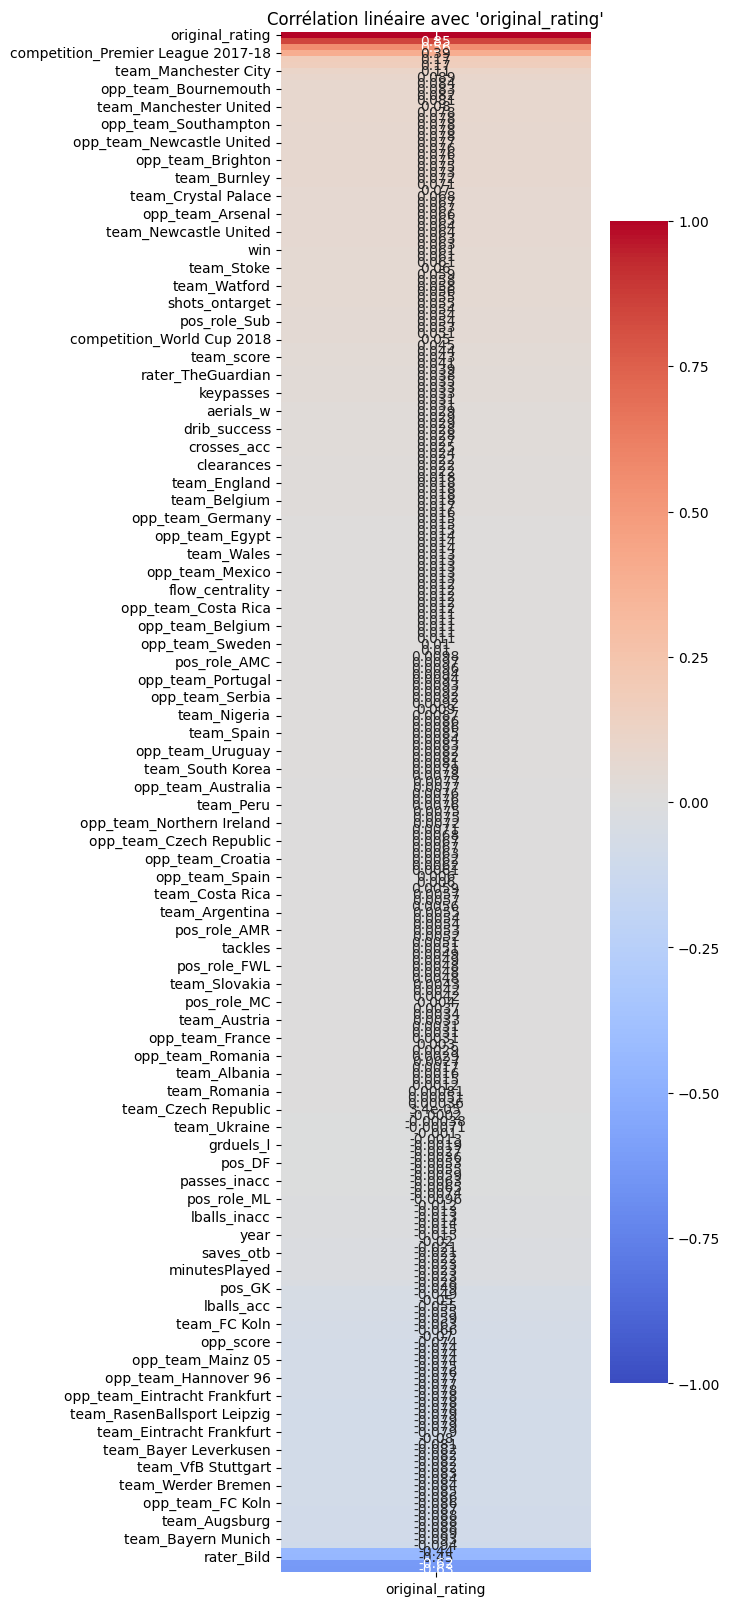

In [21]:
# Exclure la colonne 'player'
df_no_player = df.drop(columns=['player', 'competition', 'match', 'team', 'pos', 'pos_role', 'rater','opp_team', 'date'])

# Calculer la corrélation linéaire (Pearson) entre 'original_rating' et les autres variables
correlation = df_no_player.corr()[['original_rating']].sort_values(by='original_rating', ascending=False)

# Créer une heatmap des corrélations linéaires
plt.figure(figsize=(5, 20))
sns.heatmap(correlation, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title("Corrélation linéaire avec 'original_rating'")
plt.show()

C:\Users\busch\AppData\Local\Temp\ipykernel_12864\41219236.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')


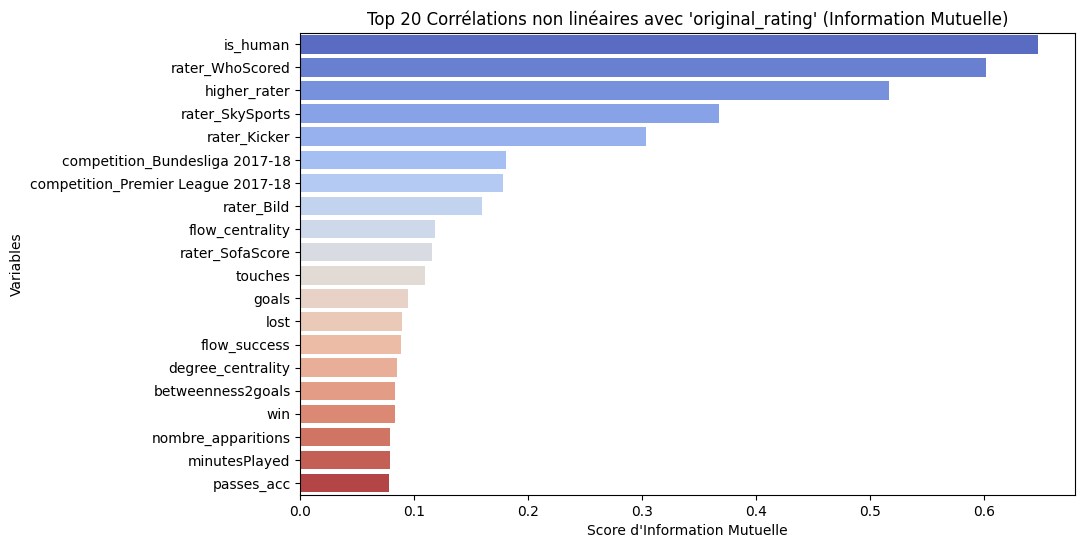

In [22]:
# Calculer la corrélation non linéaire avec l'information mutuelle
X = df_no_player.drop(columns=['original_rating'])
y = df_no_player['original_rating']

X = df_no_player.drop(columns=['original_rating'])
y = df_no_player['original_rating']

X = X.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.dtype in ['int64', 'float64'] else x)

mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

mi_scores_df = mi_scores_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df, palette='coolwarm')
plt.title("Top 20 Corrélations non linéaires avec 'original_rating' (Information Mutuelle)")
plt.xlabel("Score d'Information Mutuelle")
plt.ylabel("Variables")
plt.show() 

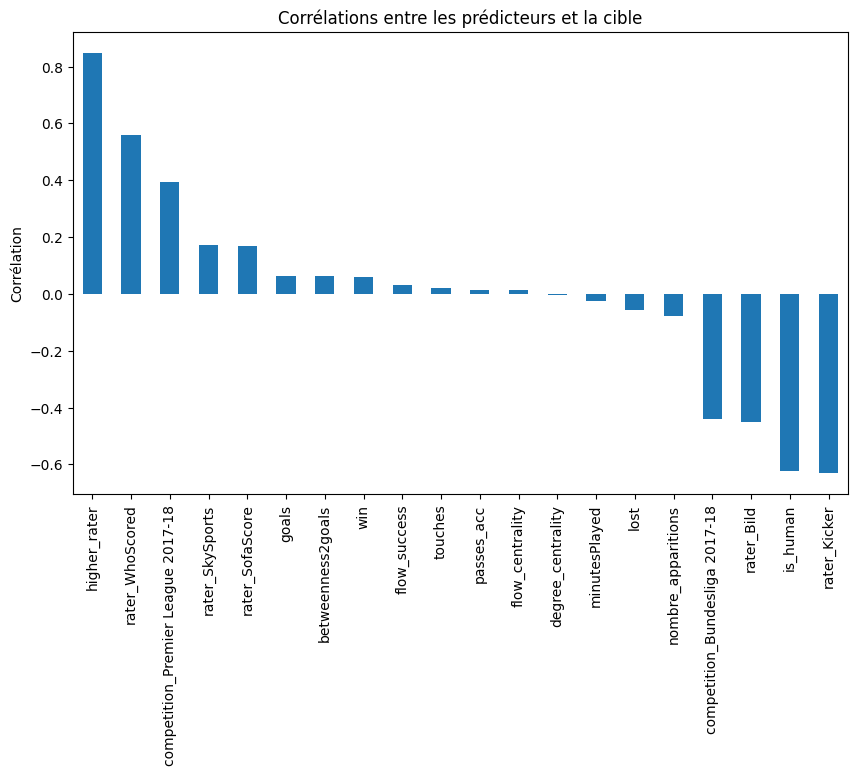

In [23]:
correlations = X[mi_scores_df.Feature].corrwith(y).sort_values(ascending=False)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title("Corrélations entre les prédicteurs et la cible")
plt.ylabel("Corrélation")
plt.show()

# V. Notation par journal

In [24]:
# Clustering
pivot_df = df.pivot_table(values='original_rating', index='team', columns='rater', aggfunc=np.mean)

scaler = StandardScaler()
scaled_df = scaler.fit_transform(pivot_df.fillna(0)) 
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_df)
pivot_df['Cluster_country'] = clusters

tools.display_dataframe_to_user("Groupes par Similarités", pivot_df)

C:\Users\busch\AppData\Local\Temp\ipykernel_12864\3808469811.py:2: FutureWarning: The provided callable <function mean at 0x0000020F6FC34D60> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = df.pivot_table(values='original_rating', index='team', columns='rater', aggfunc=np.mean)


Groupes par Similarités


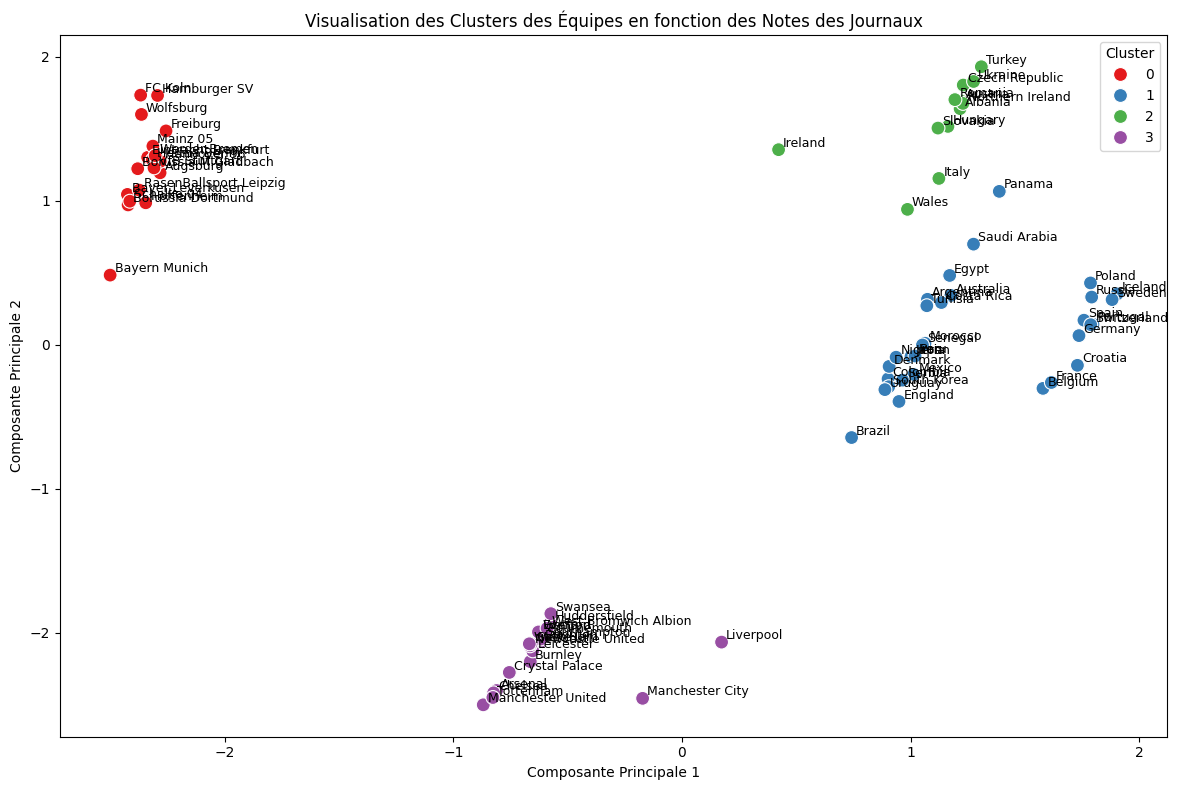

In [25]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)

pivot_df['PCA1'] = pca_result[:, 0]
pivot_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_country', data=pivot_df, palette='Set1', s=100)

for i in range(pivot_df.shape[0]):
    plt.text(pivot_df['PCA1'].iloc[i]+0.02, pivot_df['PCA2'].iloc[i]+0.02, 
             pivot_df.index[i], fontsize=9)

plt.title('Visualisation des Clusters des Équipes en fonction des Notes des Journaux')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

In [26]:
english_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City', 'Manchester United', 'Tottenham', 'Watford', 'West Bromwich Albion',
                'Huddersfield', 'Leicester', 'Everton', 'Stoke', 'Southampton', 'Swansea','Bournemouth', 'Crystal Palace', 'Brighton', 'Newcastle United', 'West Ham']
german_clubs = ['Bayern Munich', 'Borussia Dortmund', 'RB Leipzig', 'Augsburg', 'Werder Bremen', 'Schalke 04', 'Wolfsburg', 'Bayer Leverkusen', 'Hamburger SV',
               'RasenBallsport Leipzig', 'Hannover 96', 'VfB Stuttgart', 'Mainz 05', 'Hoffenheim', 'Hertha Berlin',	'Borussia M.Gladbach', 'FC Koln',
                'Eintracht Frankfurt', 'Freiburg']
european_national_teams = ['France', 'Germany', 'Italy', 'Spain', 'Portugal', 'Netherlands', 'Belgium', 'England', 'Romania', 'Albania', 'Austria', 'Switzerland', 'Croatia', 
                           'Czech Republic', 'Denmark', 'Iceland', 'Ireland', 'Northern Ireland', 'Poland', 'Russia', 'Serbia',	'Slovakia', 'Sweden', 'Turkey', 'Ukraine', 'Wales']
rest_of_world_national_teams = list(set(df['team'].unique()) - set(english_clubs) - set(german_clubs) - set(european_national_teams))

df['English_Club'] = df['team'].apply(lambda x: 1 if x in english_clubs else 0)
df['German_Club'] = df['team'].apply(lambda x: 1 if x in german_clubs else 0)
df['European_National_Team'] = df['team'].apply(lambda x: 1 if x in european_national_teams else 0)
df['Rest_of_World_National_Team'] = df['team'].apply(lambda x: 1 if x in rest_of_world_national_teams else 0)

In [ ]:
dummies = ['English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team']
count_by_dummy_correct = df.melt(id_vars=['rater'], value_vars=dummies, var_name='Category', value_name='Is_Present')
count_summary = count_by_dummy_correct[count_by_dummy_correct['Is_Present'] == 1].groupby(['Category', 'rater']).size().unstack(fill_value=0)

tools.display_dataframe_to_user("Nombre de joueurs notés par chaque journal pour chaque catégorie de dummies (correct)", count_summary)

Nombre de joueurs notés par chaque journal pour chaque catégorie de dummies (correct)


In [28]:
journal_nationalities = {
    'Bild': 'Germany',
    'Kicker': 'Germany',
    'SkySports': 'UK',
    'SofaScore': 'Int',
    'TheGuardian': 'UK',
    'WhoScored': 'Int'
}

for nationality_rater in set(journal_nationalities.values()):
    df[nationality_rater] = df['rater'].apply(lambda x: 1 if journal_nationalities.get(x) == nationality_rater else 0)

In [29]:
team_nationality_map = df[['team', 'English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team']].drop_duplicates()

def get_team_nationality(row):
    if row['English_Club'] == 1:
        return 'English Club'
    elif row['German_Club'] == 1:
        return 'German Club'
    elif row['European_National_Team'] == 1:
        return 'European National Team'
    elif row['Rest_of_World_National_Team'] == 1:
        return 'Rest of World National Team'
    else:
        return 'Unknown'

team_nationality_map['Team_Nationality'] = team_nationality_map.apply(get_team_nationality, axis=1)

df = df.merge(team_nationality_map[['team', 'Team_Nationality']], on='team', how='left')

def get_journal_nationality(rater):
    return journal_nationalities.get(rater, 'Other')

df['Journal_Nationality'] = df['rater'].apply(get_journal_nationality)

In [30]:
avg_ratings = df.groupby(['team', 'Team_Nationality', 'Journal_Nationality'])['original_rating'].mean().reset_index()
non_international_journals = ['Germany', 'UK']
avg_ratings_sorted = avg_ratings.sort_values(by='Team_Nationality')
filtered_avg_ratings = avg_ratings_sorted[avg_ratings_sorted['Journal_Nationality'].isin(non_international_journals)]

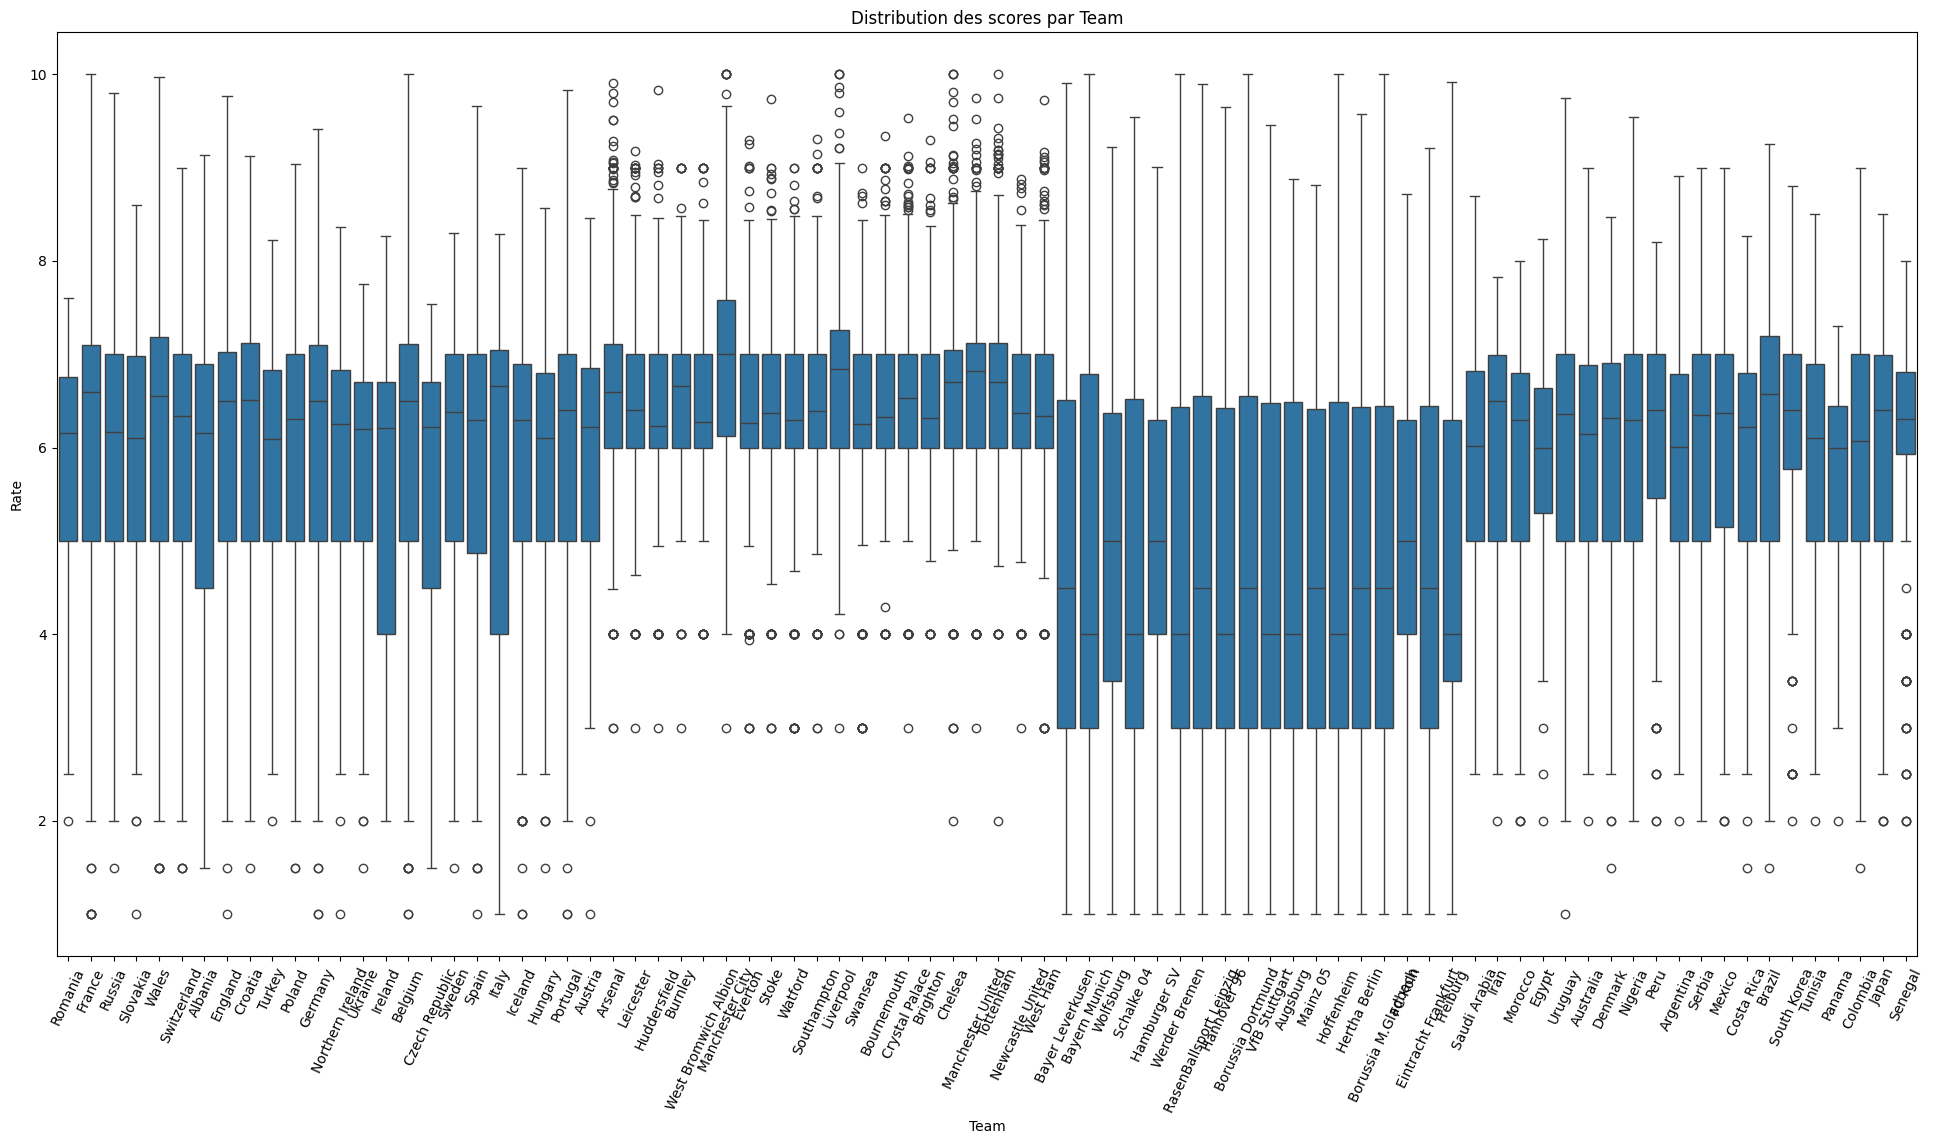

In [ ]:
plt.figure(figsize=(24, 12))
sns.boxplot(data=df, x='team', y='original_rating')
plt.title('Distribution des scores par Team')
plt.xlabel('Team')
plt.ylabel('Rate')
plt.xticks(rotation=65)
plt.show()

C:\Users\busch\AppData\Local\Temp\ipykernel_12864\1072469794.py:2: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x='team', y='original_rating', hue='Journal_Nationality', data=filtered_avg_ratings, palette = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1'])


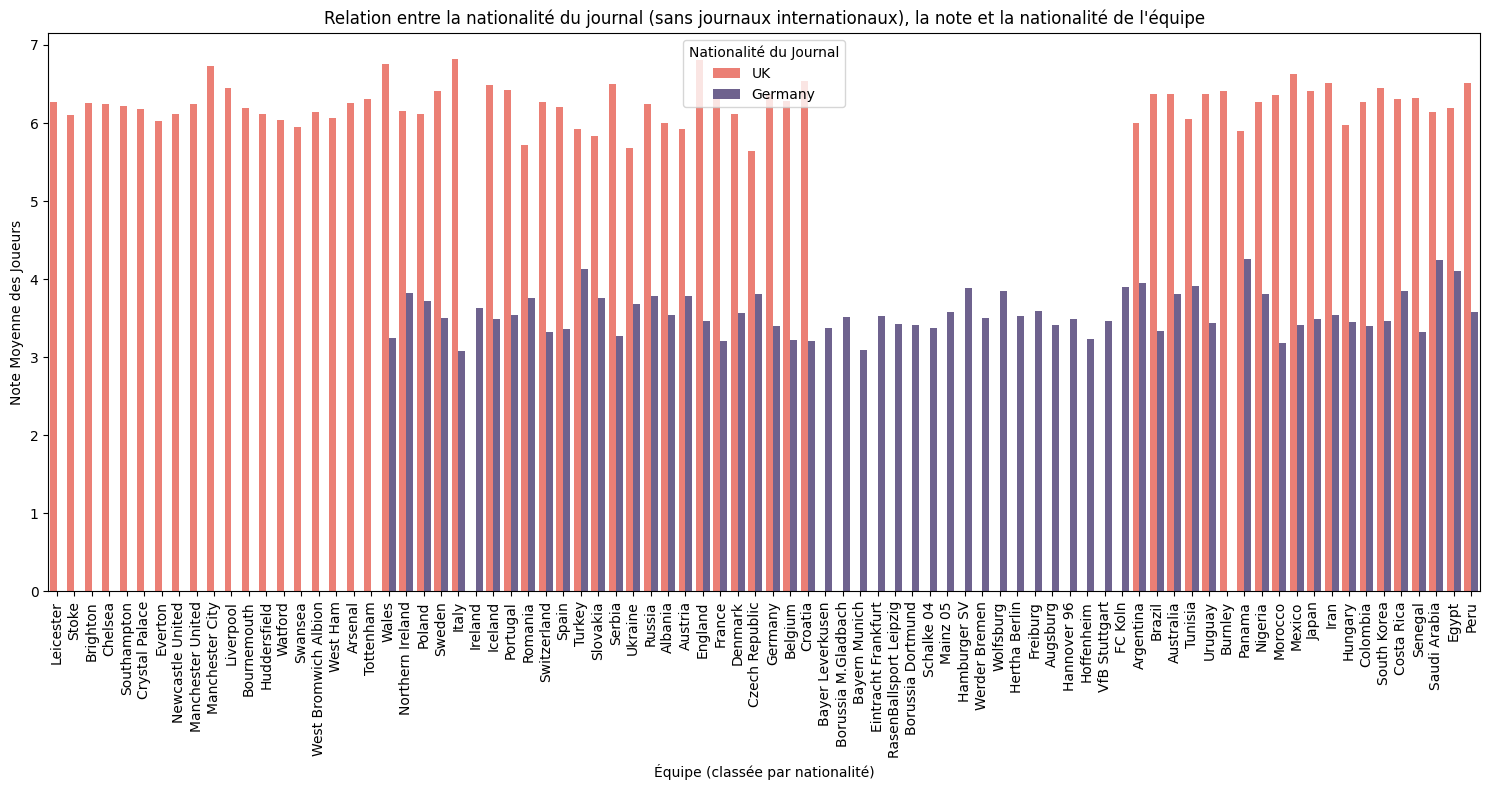

In [32]:
plt.figure(figsize=(15, 8))
sns.barplot(x='team', y='original_rating', hue='Journal_Nationality', data=filtered_avg_ratings, palette = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1'])
plt.title('Relation entre la nationalité du journal (sans journaux internationaux), la note et la nationalité de l\'équipe')
plt.xlabel('Équipe (classée par nationalité)')
plt.ylabel('Note Moyenne des Joueurs')
plt.xticks(rotation=90)
plt.legend(title='Nationalité du Journal')

plt.tight_layout()
plt.show()

# VI. Critères d'annotation des noteurs

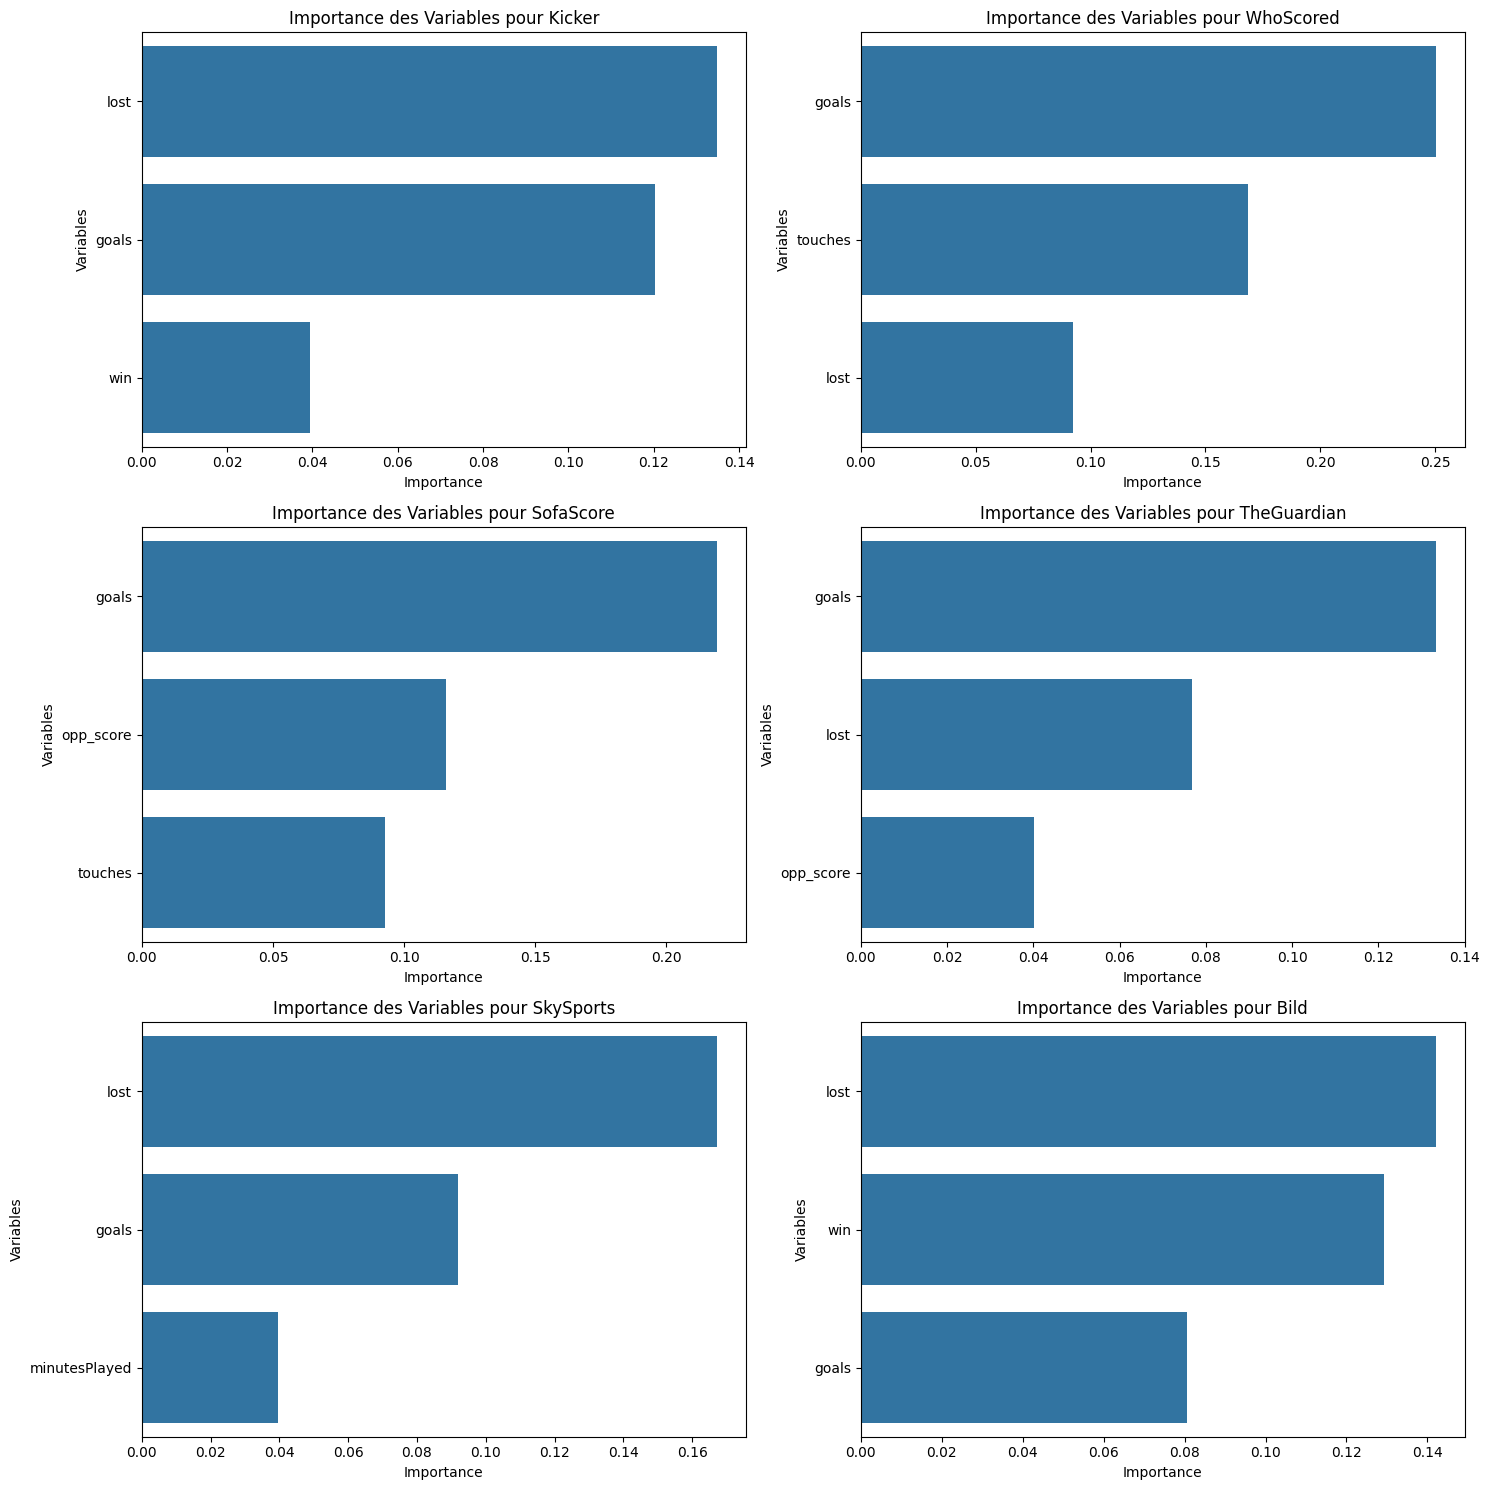

In [33]:
exclude_columns = ['competition', 'date', 'match', 'team', 'pos', 'pos_role', 'player', 'rater', 'original_rating', 'Team_Nationality', 
                   "Journal_Nationality", "opp_team"]
features = df.drop(columns=exclude_columns)
features = features.fillna(0)
journals = df['rater'].unique()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

feature_importance_dict = {}

n_journals = len(journals)
fig, axes = plt.subplots(nrows=(n_journals + 1) // 2, ncols=2, figsize=(15, 5 * ((n_journals + 1) // 2)))
axes = axes.flatten()

for idx, journal in enumerate(journals):
    journal_data = df[df['rater'] == journal]
    journal_features = journal_data.drop(columns=exclude_columns)
    journal_target = journal_data['original_rating']
    journal_scaled_features = scaler.fit_transform(journal_features.fillna(0))

    X_train, X_test, y_train, y_test = train_test_split(journal_scaled_features, journal_target, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    importance = model.feature_importances_
    feature_importance = pd.Series(importance, index=journal_features.columns)
    feature_importance_dict[journal] = feature_importance.sort_values(ascending=False)

    sns.barplot(x=feature_importance.sort_values(ascending=False).values[:3], 
                y=feature_importance.sort_values(ascending=False).index[:3], 
                ax=axes[idx])
    axes[idx].set_title(f'Importance des Variables pour {journal}')
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('Variables')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

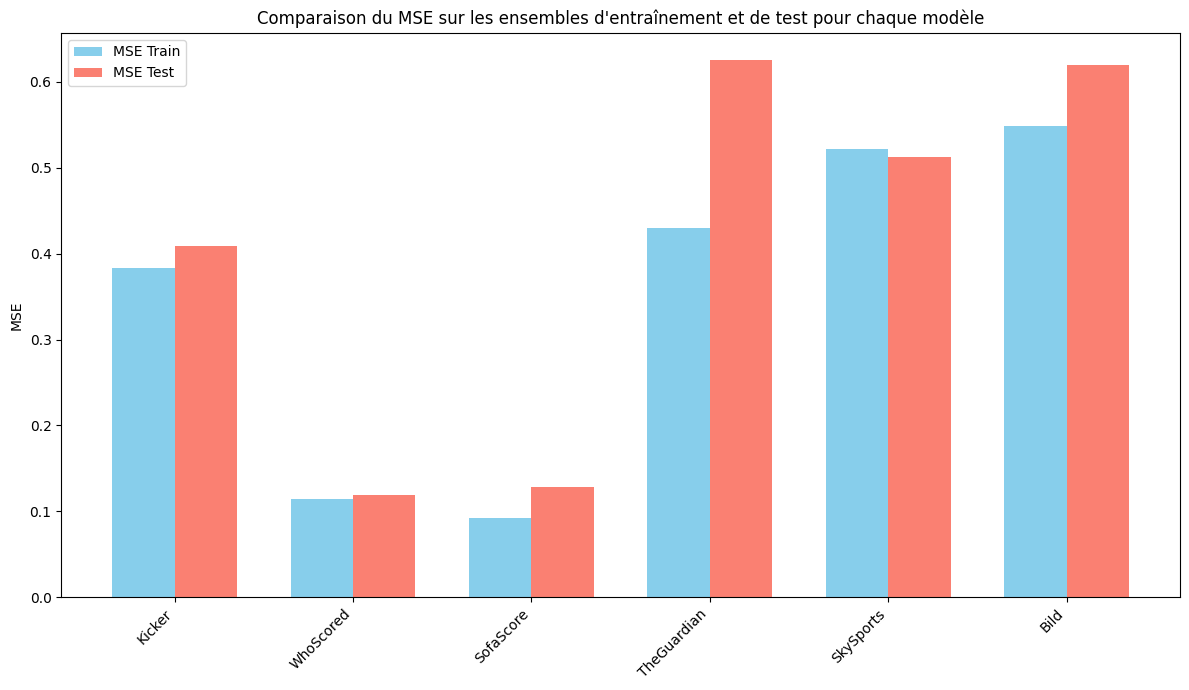

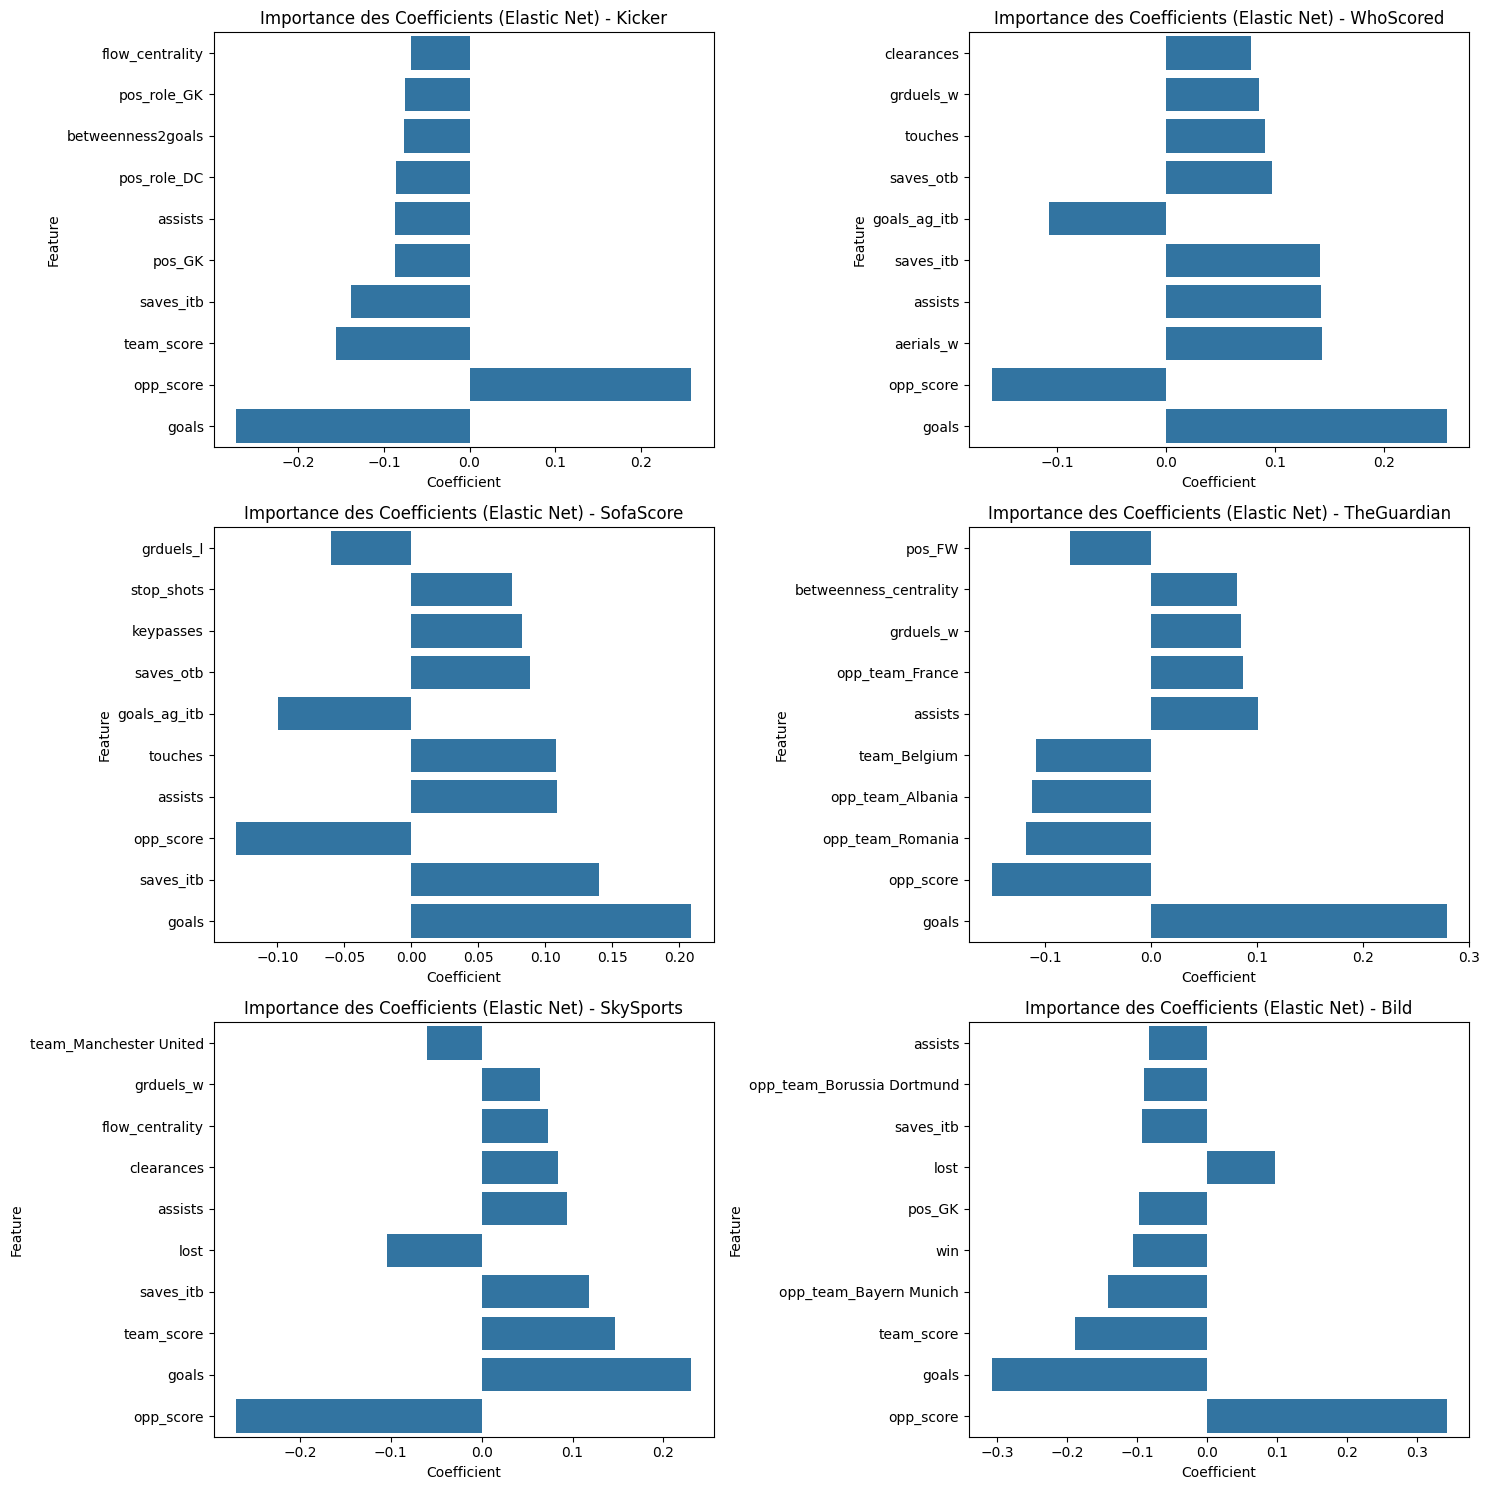

In [34]:
raters = ['Kicker', 'WhoScored', 'SofaScore', 'TheGuardian', 'SkySports', 'Bild']
exclude_columns = ['competition', 'date', 'match', 'team', 'pos', 'pos_role', 'player', 'Team_Nationality', 
                   "Journal_Nationality", "opp_team"]

coef_results = {}
mse_results = {}
coeff_plots_data = {}

param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}

df2 = df.drop(columns=exclude_columns)

def process_rater(rater):
    df_subset = df2[df2['rater'] == rater].copy()
    df_subset.drop(columns=['rater'], inplace=True)

    X = df_subset.drop(columns=['original_rating'])
    Y = df_subset['original_rating']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

    elastic_net = ElasticNet(random_state=42)
    grid_search = GridSearchCV(
        estimator=elastic_net,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=0,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    coefficients = best_model.coef_
    feature_names = X.columns
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    return rater, coef_df, mse_train, mse_test

results = Parallel(n_jobs=-1)(delayed(process_rater)(rater) for rater in raters)

for rater, coef_df, mse_train, mse_test in results:
    coef_results[rater] = coef_df
    mse_results[rater] = {'MSE_train': mse_train, 'MSE_test': mse_test}

raters_list = list(mse_results.keys())
mse_train_list = [mse_results[rater]['MSE_train'] for rater in raters_list]
mse_test_list = [mse_results[rater]['MSE_test'] for rater in raters_list]

x = np.arange(len(raters_list))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
bars_train = ax.bar(x - width/2, mse_train_list, width, label='MSE Train', color='skyblue')
bars_test = ax.bar(x + width/2, mse_test_list, width, label='MSE Test', color='salmon')

ax.set_ylabel('MSE')
ax.set_title("Comparaison du MSE sur les ensembles d'entraînement et de test pour chaque modèle")
ax.set_xticks(x)
ax.set_xticklabels(raters_list, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for idx, rater in enumerate(raters_list):
    coef_df = coef_results[rater]
    sns.barplot(x=coef_df['Coefficient'].head(10), y=coef_df['Feature'].head(10), ax=axes[idx])
    axes[idx].set_title(f"Importance des Coefficients (Elastic Net) - {rater}")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

# En conclusion:

Choix du journal: 

    ['higher_rater','is_human']

Compétition:

    ['competition_Bundesliga 2017-18','competition_World Cup 2018','competition_Premier League 2017-18']
    
Caractéristiques de jeux:

    ['flow_centrality','goals','win','minutesPlayed','nombre_apparitions','Substitute']

Nationnalité:

    ['English_Club', 'German_Club', 'European_National_Team', 'Rest_of_World_National_Team'] 

Caractéristiques Temporelles:

    ['year', 'semester']	